In [1]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid, VoronoiDelaunayGrid
from landlab.plot import imshow_grid

### Illustration of the problem

First, let's set up a simple Gaussian surface. This example will be analogous to the shallow ice problem on a perfectly flat bed with no mass balance.

In [18]:
nx, ny = (100, 100)
dx = 100

grid = RasterModelGrid((nx, ny), dx)

scale = nx*dx
surface = 1000 * np.exp(-(((mg.node_x - scale/2) / (scale/2))**2 + ((mg.node_y - scale/2) / (scale/2))**2), dtype = np.float64)
grid.add_field('surface', surface, at = 'node')

array([ 135.33528324,  140.80208882,  146.37257855, ...,  158.18342525,
        152.28523052,  146.48972346])

Plot the initial surface.

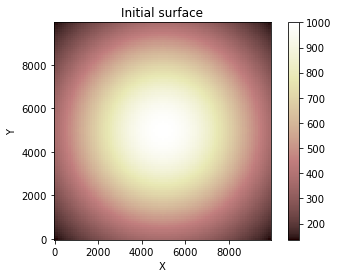

In [19]:
imshow_grid(grid, 'surface')
plt.title('Initial surface')
plt.show()

Now, take the gradient of that surface, and the divergence of that gradient. This is the linear case.

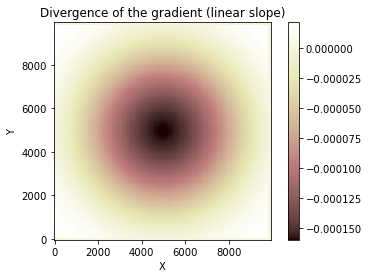

In [31]:
g = grid.calc_grad_at_link('surface')
d = grid.calc_flux_div_at_node(g)

imshow_grid(grid, d)
plt.title('Divergence of the gradient (linear slope)')
plt.show()

This time, take the gradient of the surface, and multiply by the surface itself to the fourth power. We will re-map the surface to links using an upwind scheme.

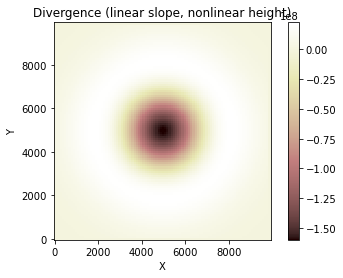

In [29]:
g = grid.calc_grad_at_link('surface')
h4 = grid.at_node['surface']**4
grid.add_field('h4', h4, at = 'node', clobber = True)
h4_upwind = grid.map_value_at_max_node_to_link('surface', 'h4')

d = grid.calc_flux_div_at_node(g*h4_upwind)
imshow_grid(grid, d)
plt.title('Divergence (linear slope, nonlinear height)')
plt.show()

Lastly, we will take the nonlinear slope, and the linear height.

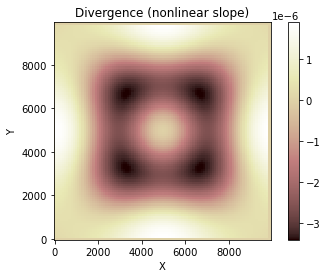

In [53]:
g = grid.calc_grad_at_link('surface')
d = grid.calc_flux_div_at_node(g**3)
imshow_grid(grid, d)
plt.title('Divergence (nonlinear slope)')
plt.show()

The ice sheet thickness evolves by:
$$
H_t = b - \nabla\cdot q,
$$
where $H$ is the ice thickness, $b$ is the mass balance, and $q = \bar{U}H$, where $\bar{U}$ is the depth-integrated horizontal velocity. Now, let $\bar{U}$ be a vector of two components, $u$ and $v$, corresponding to depth-integrated velocities in the $x$- and $y$-directions, respectively. Then:
$$
H_t = b - H\nabla\cdot \bar{U} - \bar{U}\cdot\nabla H.
$$
Expanded, and letting $b = 0$ for now, this can be rewritten as:
$$
\frac{\partial H}{\partial t} = H\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}\right) - \sum_{i = 1}^2 \bar{U}_i\nabla_i H,
$$
where subscripts now indicate vector components, not derivatives (as in the previous equations). 

In [100]:
grad = grid.calc_grad_at_link('surface')
gx, gy = grid.map_link_vector_components_to_node(grad)

mag, comps = grid.calc_slope_at_node('surface', return_components = True)
sx, sy = comps
surface = grid.at_node['surface']

flow_coeff = ((2/5) * 6.8e-24) * (917 * 9.81)**3
u = flow_coeff * sx**3 * surface**4
v = flow_coeff * sy**3 * surface**4

gradu = grid.calc_grad_at_link(u)
ux, uy = grid.map_link_vector_components_to_node(gradu)

gradv = grid.calc_grad_at_link(v)
vx, vy = grid.map_link_vector_components_to_node(gradv)

Ht = surface * (ux + vy) - u * gx - v * gy

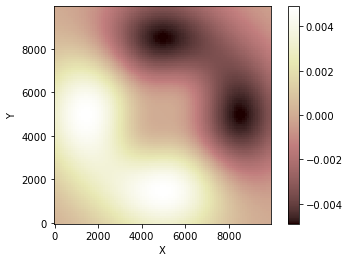

In [118]:
imshow_grid(grid, sx**3 + sy**3)

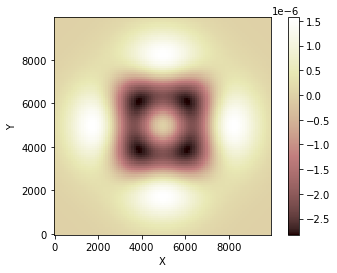

In [101]:
imshow_grid(grid, ux + vy)

### Bueler (2007) isothermal model

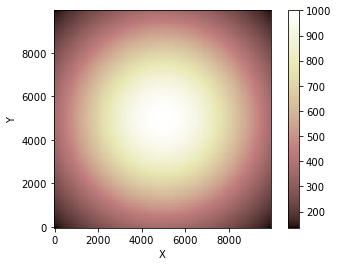

In [205]:
nx, ny = (100, 100)
dx = 100

grid = RasterModelGrid((nx, ny), dx)

scale = nx*dx
surface = 1000 * np.exp(-(((mg.node_x - scale/2) / (scale/2))**2 + ((mg.node_y - scale/2) / (scale/2))**2), dtype = np.float64)
grid.add_field('surface', surface, at = 'node')

imshow_grid(grid, 'surface')

### Voronoi-Delaunay grid

In [145]:
nodes = 10000
scale = 10000
grid = VoronoiDelaunayGrid(np.random.rand(nodes) * scale, np.random.rand(nodes) * scale)

grid.add_field('test', np.random.rand(nodes), at = 'node')

H0 = 1e3
surface = H0 * np.exp(-(((grid.node_x - scale/2) / (scale/2))**2 + ((grid.node_y - scale/2) / (scale/2))**2), dtype = np.float64)
grid.add_field('surface', surface, at = 'node')

pass

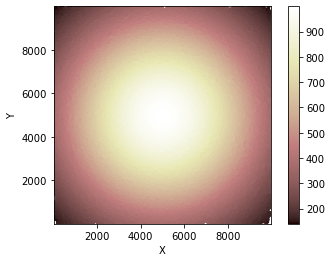

In [146]:
imshow_grid(grid, 'surface')

### HexModelGrid

In [218]:
from landlab import HexModelGrid

/home/egp/anaconda3/envs/landlab/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)


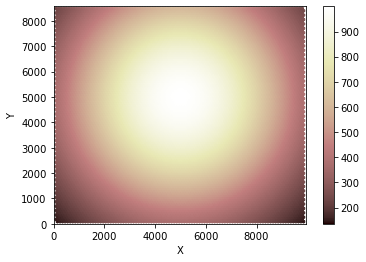

In [253]:
nx = 100
ny = 100
dx = 100
grid = HexModelGrid((nx, ny), spacing = dx, node_layout = 'rect')
H0 = 1e3
scale = nx * dx
surface = H0 * np.exp(-(((grid.node_x - scale/2) / (scale/2))**2 + ((grid.node_y - scale/2) / (scale/2))**2), dtype = np.float64)
grid.add_field('surface', surface, at = 'node')

imshow_grid(grid, 'surface')
plt.show()

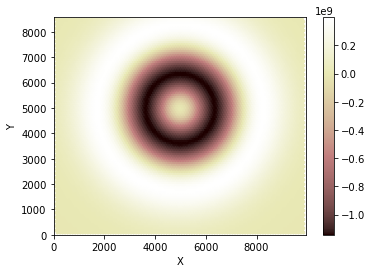

In [255]:
grad = grid.calc_grad_at_link('surface')
surf_links = grid.map_value_at_max_node_to_link('surface', 'surface')
flux = surf_links**5 * np.abs(grad)**2 * grad
div = grid.calc_flux_div_at_node(flux)

imshow_grid(grid, div)

In [263]:
class ShallowIceApproximation:
    
    def __init__(self, grid, initial_thickness):
        self.rho = 917
        self.g = 9.81
        self.A = 6.8e-24
        
        self.grid = grid
        
        self.grid.add_field('ice_thickness', initial_thickness, at = 'node', clobber = True)
        
    def run_one_step(self, dt):
        self.surface_gradient = self.grid.calc_grad_at_link('ice_thickness')
        self.thickness_at_links = self.grid.map_value_at_max_node_to_link('ice_thickness', 'ice_thickness')
        self.flow_coeff = ((2/5) * (self.rho * self.g)**3 * self.A)
        self.ice_flux = self.flow_coeff * self.thickness_at_links**5 * np.abs(self.surface_gradient)**3 * self.surface_gradient
        self.divergence = self.grid.calc_flux_div_at_node(self.ice_flux)
        self.grid.at_node['ice_thickness'] += self.divergence * dt

/home/egp/anaconda3/envs/landlab/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)


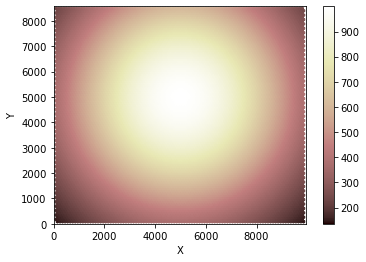

In [289]:
nx = 100
ny = 100
dx = 100
grid = HexModelGrid((nx, ny), spacing = dx, node_layout = 'rect')
H0 = 1e3
scale = nx * dx
surface = H0 * np.exp(-(((grid.node_x - scale/2) / (scale/2))**2 + ((grid.node_y - scale/2) / (scale/2))**2), dtype = np.float64)
grid.add_field('surface', surface, at = 'node')

imshow_grid(grid, 'surface')
plt.show()

In [290]:
sia = ShallowIceApproximation(grid, surface)

In [326]:
max_thickness = []
dt = 60
for i in range(10000):
    sia.run_one_step(dt)
    max_thickness.append(sia.thickness_at_links.max())

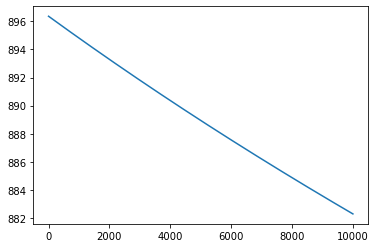

In [327]:
plt.plot(max_thickness)
plt.show()

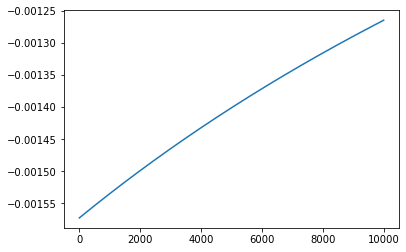

In [328]:
plt.plot(np.diff(max_thickness))
plt.show()

/home/egp/anaconda3/envs/landlab/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)


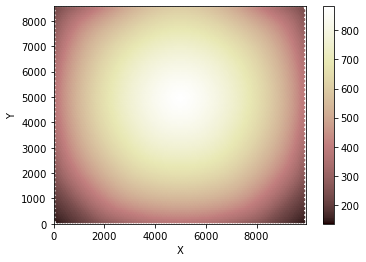

In [329]:
imshow_grid(sia.grid, 'surface')

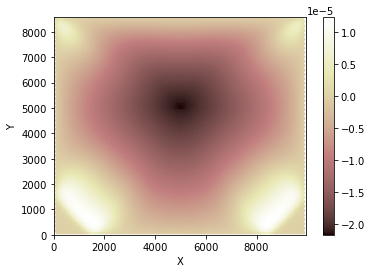

In [330]:
imshow_grid(sia.grid, sia.divergence)

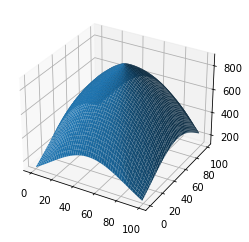

In [331]:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

nx = 100
ny = 100
x, y = np.meshgrid(range(nx), range(ny))
z = sia.grid.at_node['ice_thickness'].reshape((nx, ny))

ax.plot_surface(x, y, z)

plt.show()